# _`Exploratory Data Analysis`_

Now we are going to continue with the 'EDA', in this proccess we are going to analyze the transformed data to search for patterns and useful information that might help us at the time to make decisions before our modeling proccess.

## 0 - Fetch the data

### 0.1 - Import the libraries that we are going to use

+ Pandas will help us managing and transforming the data
+ Matplotlib, seaborn and wordcloud will help us later making visual plots of the data

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import joblib

### 0.2 - Load the data for our analysis

In [214]:
data = pd.read_csv('_src/data/movies_transformed.csv')

After uploading the data we apply the describe() function to get a brief summarize of the data

In [215]:
data.describe()

,id,popularity,release_year,runtime,vote_average,vote_count,budget,revenue,return
count,45451.000000,45451.000000,45451.000000,45205.000000,45451.000000,45451.000000,4.545100e+04,4.545100e+04,1.094200e+04
mean,107984.599745,2.926887,1991.882027,94.181905,5.624085,109.989703,4.231294e+06,1.111071e+07,2.162755e+06
std,112111.336735,6.006458,24.057726,38.329504,1.915424,491.352336,1.742942e+07,6.381606e+07,1.131492e+07
min,2.000000,0.000000,1874.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.147484e+09,-9.060000e+00
25%,26367.500000,0.389095,1978.000000,85.000000,5.000000,3.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,59871.000000,1.131386,2001.000000,95.000000,6.000000,10.000000,0.000000e+00,0.000000e+00,1.265000e+00
75%,156327.500000,3.694370,2010.000000,107.000000,6.800000,34.000000,0.000000e+00,0.000000e+00,7.107500e+00
max,469172.000000,547.488298,2020.000000,1256.000000,10.000000,14075.000000,3.800000e+08,2.068224e+09,3.552983e+08


## 1 - Data proccessing for analytical purposes

### 1.1 Data Selection
First lets see the features we have

In [216]:
data.columns

Index(['collection_name', 'directors', 'genres_list', 'id', 'title',
       'prod_companies', 'prod_countries', 'original_language', 'overview',
       'popularity', 'release_date', 'release_year', 'runtime', 'status',
       'tagline', 'vote_average', 'vote_count', 'budget', 'revenue', 'return'],
      dtype='object')

##### Having knowledge of the data domain, we will focus on the features that we believe are most valuable in obtaining information from the data.

The columns that we are going to use will be: 
+ directors 
+ genres_list
+ prod_companies
+ popularity
+ vote_average
+ vote_count

In [217]:
#We make a distinct dataframe so we do not affect the original data
eda_data = data[['id','directors','genres_list','prod_companies','popularity','vote_average','vote_count']].copy()

### 1.2 Values inputation and aggregated columns

#### 1.2.1 NaN values

For the categorical features, as we do not want to lose information lets setting their value as an empty space

In [218]:
fill_values = {'directors': '', 'prod_companies': '', 'genres_list': ''}
data.fillna(fill_values, inplace=True)
eda_data.fillna(fill_values, inplace=True)

#### 1.2.2 data:encoding proccess 

Before the plot lets make a correlation matrix to get an idea of which features can be correlated, but for this to be possible we need to make a data:encoding of the categorical features as the correlation matrix only understand numerical values

##### To make a data:encoding dictionary we first need to get each distinct element of the feature. For this, I am going to make a function that helps me in this task 

In [219]:
#Function to get the elements of the feature
elements = []
def get_elements(element_str): 
    if type(element_str) == str:
        elements_list = element_str.split(',')
        for element in elements_list:
            if element not in elements: elements.append(element)

##### Get the distincts elements of each feature

In [220]:
#Directors 
elements = []
eda_data['directors'].apply(get_elements)
directors_dict = {}
for i, director in enumerate(elements):
    directors_dict[director] = i

#Genres
elements = []
eda_data['genres_list'].apply(get_elements)
genres_dict = {}
for i, genre in enumerate(elements):
    genres_dict[genre] = i     

#Prod Companies
elements = []
eda_data['prod_companies'].apply(get_elements)
company_dict = {}
for i, company in enumerate(elements):
    company_dict[company] = i

print(genres_dict)

{'Animation': 0, 'Comedy': 1, 'Family': 2, 'Adventure': 3, 'Fantasy': 4, 'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9, 'Horror': 10, 'History': 11, 'Science Fiction': 12, 'Mystery': 13, 'War': 14, 'Foreign': 15, '': 16, 'Music': 17, 'Documentary': 18, 'Western': 19, 'TV Movie': 20}


#### To make the correlation matrix it will be useful to have a value per column, so for practical purposes we will keep the first director, production company and the first three genres of each movie

##### Define the functions that will help us in this task

In [221]:
#Returns the first element of a list like str 'comedy, 'action','romance' -> 'comedy'
def get_first(element_str): 
    if type(element_str) == str:
        element_list = element_str.split(',')
        return element_list[0]
#Returns the second element of a list like str 'comedy, 'action','romance' -> 'action'
def get_second(element_str):
    if type(element_str) == str:
        element_list = element_str.split(',')
        if len(element_list) >= 2: return element_list[1]
        else: return ''
#Returns the third element of a list like str 'comedy, 'action','romance' -> 'romance'
def get_third(element_str):
    if type(element_str) == str:
        element_list = element_str.split(',')
        if len(element_list) >= 3: return element_list[2]
        else: return ''   

##### Apply the created functions to get our new columns

Create the director and company column

In [222]:
eda_data['director'] = data['directors'].apply(get_first)
eda_data['prod_company'] = data['prod_companies'].apply(get_first)

Create the first three genres columns

In [223]:
eda_data['genre_1'] = data['genres_list'].apply(get_first)
eda_data['genre_2'] = data['genres_list'].apply(get_second)
eda_data['genre_3'] = data['genres_list'].apply(get_third)

##### Lets see our dataframe to see if the transformations were made successfully

In [224]:
eda_data.head()

,id,directors,genres_list,prod_companies,popularity,vote_average,vote_count,director,prod_company,genre_1,genre_2,genre_3
0,862,John Lasseter,"Animation,Comedy,Family",Pixar Animation Studios,21.946943,7.7,5415.0,John Lasseter,Pixar Animation Studios,Animation,Comedy,Family
1,8844,Joe Johnston,"Adventure,Fantasy,Family","TriStar Pictures,Teitler Film,Interscope Commu...",17.015539,6.9,2413.0,Joe Johnston,TriStar Pictures,Adventure,Fantasy,Family
2,15602,Howard Deutch,"Romance,Comedy","Warner Bros.,Lancaster Gate",11.712900,6.5,92.0,Howard Deutch,Warner Bros.,Romance,Comedy,
3,31357,Forest Whitaker,"Comedy,Drama,Romance",Twentieth Century Fox Film Corporation,3.859495,6.1,34.0,Forest Whitaker,Twentieth Century Fox Film Corporation,Comedy,Drama,Romance
4,11862,Charles Shyer,Comedy,"Sandollar Productions,Touchstone Pictures",8.387519,5.7,173.0,Charles Shyer,Sandollar Productions,Comedy,,


##### It were! Now we have to encode the data into numerical values (We already have the dictionary data:encoding so we need to create the functions and it is done ;)

In [225]:
def encode_genres(data_str):
    if type(data_str) == str:
        if len(data_str) >= 3: return genres_dict[data_str]
        else: return None

def encode_director(data_str):
    if type(data_str) == str:
        if len(data_str) >= 3: return directors_dict[data_str]
        else: return None
        
def encode_company(data_str):
    if type(data_str) == str:
        if len(data_str) >= 3: return company_dict[data_str]
        else: return None            

##### Apply the functions to encode the columns

In [226]:
eda_data['genre_1'] = eda_data['genre_1'].apply(encode_genres)
eda_data['genre_2'] = eda_data['genre_2'].apply(encode_genres)
eda_data['genre_3'] = eda_data['genre_3'].apply(encode_genres)
eda_data['director'] = eda_data['director'].apply(encode_director)
eda_data['prod_company'] = eda_data['prod_company'].apply(encode_company)

##### Did it work?

In [227]:
eda_data.head()

,id,directors,genres_list,prod_companies,popularity,vote_average,vote_count,director,prod_company,genre_1,genre_2,genre_3
0,862,John Lasseter,"Animation,Comedy,Family",Pixar Animation Studios,21.946943,7.7,5415.0,0.0,0.0,0.0,1.0,2.0
1,8844,Joe Johnston,"Adventure,Fantasy,Family","TriStar Pictures,Teitler Film,Interscope Commu...",17.015539,6.9,2413.0,1.0,1.0,3.0,4.0,2.0
2,15602,Howard Deutch,"Romance,Comedy","Warner Bros.,Lancaster Gate",11.712900,6.5,92.0,2.0,4.0,5.0,1.0,NaN
3,31357,Forest Whitaker,"Comedy,Drama,Romance",Twentieth Century Fox Film Corporation,3.859495,6.1,34.0,3.0,6.0,1.0,6.0,5.0
4,11862,Charles Shyer,Comedy,"Sandollar Productions,Touchstone Pictures",8.387519,5.7,173.0,4.0,7.0,1.0,NaN,NaN


##### Yes, it did! Now that we have our numerical data we can drop the categorical ones to make the correlation matrix.

In [228]:
eda_data.drop(columns='directors', inplace=True)
eda_data.drop(columns='prod_companies', inplace=True)
eda_data.drop(columns='genres_list', inplace=True)

## 2 Statistical Analysis

Let's examine the correlation matrix to create plots and identify the relation between the features.

In [229]:
mapa = eda_data.corr()
mapa.style.background_gradient(cmap='coolwarm')

,id,popularity,vote_average,vote_count,director,prod_company,genre_1,genre_2,genre_3
id,1.000000,-0.082434,-0.165146,-0.064421,0.469718,0.279894,0.122407,0.025972,0.006136
popularity,-0.082434,1.000000,0.153814,0.559846,-0.178558,-0.068137,-0.076586,-0.062048,-0.061351
vote_average,-0.165146,0.153814,1.000000,0.123556,-0.131010,-0.017303,-0.038488,-0.031363,-0.033753
vote_count,-0.064421,0.559846,0.123556,1.000000,-0.129634,-0.078958,-0.050777,-0.050678,-0.045127
director,0.469718,-0.178558,-0.131010,-0.129634,1.000000,0.342648,0.089235,0.020369,-0.012569
prod_company,0.279894,-0.068137,-0.017303,-0.078958,0.342648,1.000000,0.027475,0.024061,0.017314
genre_1,0.122407,-0.076586,-0.038488,-0.050777,0.089235,0.027475,1.000000,0.161071,0.100927
genre_2,0.025972,-0.062048,-0.031363,-0.050678,0.020369,0.024061,0.161071,1.000000,0.150555
genre_3,0.006136,-0.061351,-0.033753,-0.045127,-0.012569,0.017314,0.100927,0.150555,1.000000


#### Now that we have a more grafical way to know the correlation lets make some plots to see the distribution between variables.

### 2.1 plots

#### Distribution between vote_count and popularity

(0.0, 50.0)

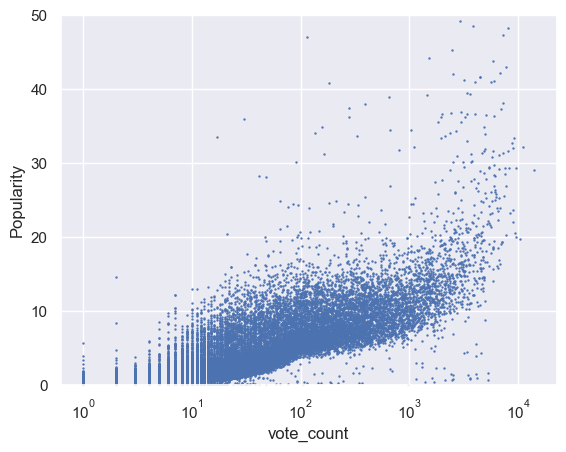

In [230]:
sns.set()
plt.scatter(eda_data['vote_count'], eda_data['popularity'], s = 0.5, )

plt.xlabel('vote_count')
plt.xscale('log')

plt.ylabel('Popularity')
plt.ylim(0, 50)

We can say that:
+ As the Popularity increases, the vote_count does too.
+ The majority of the data is between: popularity{4...12} and vote_count(v) {10...100}

#### Distribution between vote_average and vote_count

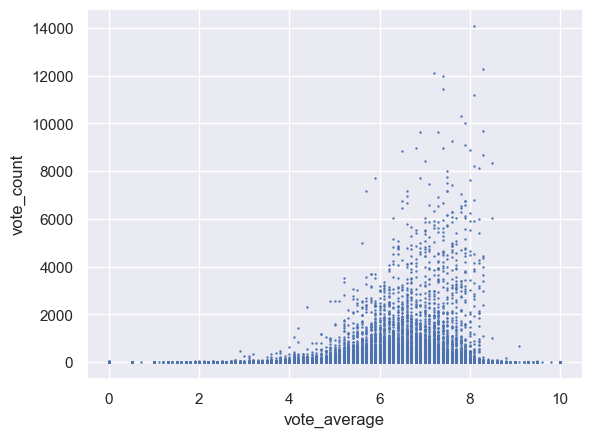

In [231]:
sns.set()
plt.scatter(eda_data['vote_average'], eda_data['vote_count'], s = 0.5, )

plt.xlabel('vote_average')

plt.ylabel('vote_count');

We can observe that:
+ The data is skewed to the left.
+ The majority of the data is between: vote_count{1...3000} and vote_average{5...8}

#### Distribution between vote_average and popularity

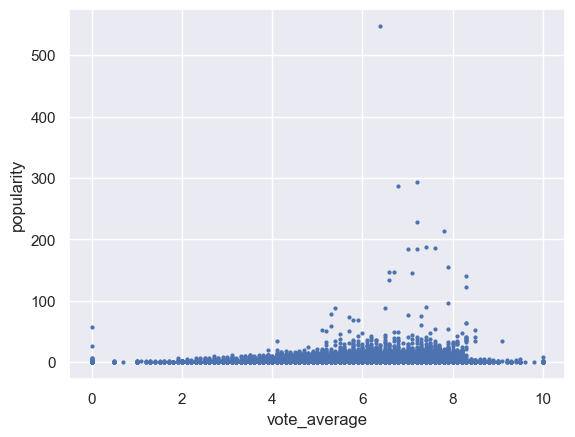

In [232]:
sns.set()
plt.scatter( eda_data['vote_average'], eda_data['popularity'], s = 4, )

plt.xlabel('vote_average')

plt.ylabel('popularity');

We can observe an outlier, it does not mean the data is wrong, but we have to take it into account if we do further analysis.

#### I want to know if there are any directors whose popularity's mean is higher compared to the rest. So lets group the data

In [233]:
director_popularity = eda_data.groupby('director')['popularity'].mean()

#### Distribution between director and mean_popularity

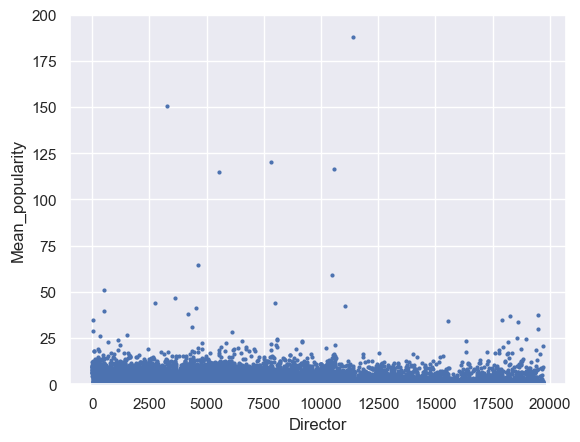

In [234]:
sns.set()
plt.scatter(director_popularity.index, director_popularity.iloc[:], s = 4, )

plt.xlabel('Director')

plt.ylabel('Mean_popularity')
plt.ylim(0,200);

##### There are some directors that highlights of the rest

#### And the last plot will be a wordcloud to see which are those genres that are the most in movies 

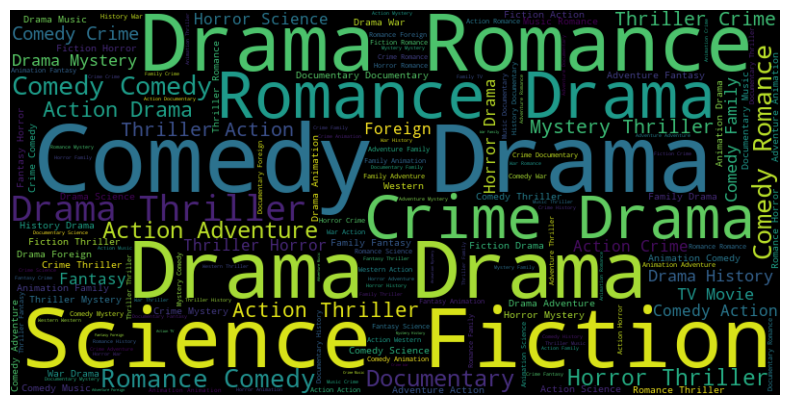

In [235]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(data['genres_list'].fillna('')))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2.2 Decisions

#### Because our goal is to make a recommendation-model we are going to keep the data with a popularity greater or equal to 5 and a vote_count greater or equal than 50

In [236]:
data.drop(data[(data['popularity'] <= 5) & (data['vote_count'] <= 50)].index, inplace= True)

##### And keep those movies with a vote_average greater or equal to 5

In [237]:
data.drop(data[(data['vote_average'] <= 5)].index, inplace=True)

## 3 - Data proccessing for modeling purposes

#### The model will give recomendation based on the cosine similarity, for this we are going to use directors, prod_companies and genre_lists which we already see have a high correlation with the movie.

### 3.1 Create the token_data column

##### We have to create a column where we are going to have our features elements as a token_data with the purpose of converting the collection of text documents into a matrix of token counts.

In [238]:
model_data = data.copy()

model_data['token_data'] = model_data['directors'] + ' '
model_data['token_data'] += (model_data['genres_list']) + ' '
model_data['token_data'] += model_data['prod_companies'] 
model_data['token_data'] = model_data['token_data'].str.replace(',',' ')


for i in range(10):
    model_data['token_data'] = model_data['token_data'].str.replace(f'{i}','')

In [239]:
model_data.head(3)

,collection_name,directors,genres_list,id,title,prod_companies,prod_countries,original_language,overview,popularity,...,release_year,runtime,status,tagline,vote_average,vote_count,budget,revenue,return,token_data
0,Toy Story Collection,John Lasseter,"Animation,Comedy,Family",862,Toy Story,Pixar Animation Studios,United States of America,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,1995,81.0,Released,NaN,7.7,5415.0,30000000,373554033,12.45,John Lasseter Animation Comedy Family Pixar An...
1,NaN,Joe Johnston,"Adventure,Fantasy,Family",8844,Jumanji,"TriStar Pictures,Teitler Film,Interscope Commu...",United States of America,en,When siblings Judy and Peter discover an encha...,17.015539,...,1995,104.0,Released,Roll the dice and unleash the excitement!,6.9,2413.0,65000000,262797249,4.04,Joe Johnston Adventure Fantasy Family TriStar ...
2,Grumpy Old Men Collection,Howard Deutch,"Romance,Comedy",15602,Grumpier Old Men,"Warner Bros.,Lancaster Gate",United States of America,en,A family wedding reignites the ancient feud be...,11.712900,...,1995,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,0,0,NaN,Howard Deutch Romance Comedy Warner Bros. Lanc...


#### Because we have limited processing power we are going to work with a reduced dataset of the first 7000 instances

In [240]:
reduced_data = model_data.head(7000)

### 3.2 Create the cosine similarity matrix and save it 

##### Create the classification matrix and calculate the cosine similarity matrix

In [241]:
vectorizer = CountVectorizer()

classification_matrix = vectorizer.fit_transform(reduced_data['token_data'])

cosine_sim = cosine_similarity(classification_matrix)

##### Now that we already procceced the cosine similarity we will storage it as a compressed file, because the file's size is too big

In [242]:
# storage the cosine similarity matrix as a compressed file with joblib
joblib.dump(cosine_sim, '_src/data/cosine_sim.pkl', compress=True)

['_src/data/cosine_sim.pkl']

In [243]:
reduced_data.to_csv('_src/data/model_data.csv')

## Now our work here is over, the next step is to create the recommendation system model ;)

#### Create the recommendation function

In [245]:
def recommendation(title: str):
    index = model_data[model_data['title'] == title].index[0]
    #Make a index-similarity list of tuples
    sim_scores = list(enumerate(cosine_sim[index]))
    #Sort the scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Recomend the first 5 movies with the most similarity
    top_recommendations = []
    for i in range(1,6):
        top_recommendations.append([])
        top_recommendations[i-1] = {'title':model_data.iloc[sim_scores[i][0]].title, 
                            'vote_average': str(model_data.iloc[sim_scores[i][0]].vote_average), 
                            'genres_list': model_data.iloc[sim_scores[i][0]].genres_list,
                            'directors': model_data.iloc[sim_scores[i][0]].directors}
    return {"title": str(title), "recommendations": top_recommendations}

#### Test it

In [247]:
recommendation('Cinderella')

{'title': 'Cinderella',
 'recommendations': [{'title': 'Jaws 2',
   'vote_average': '5.9',
   'genres_list': 'Horror,Thriller',
   'directors': 'Jeannot Szwarc'},
  {'title': 'Psycho III',
   'vote_average': '5.4',
   'genres_list': 'Horror,Thriller',
   'directors': 'Anthony Perkins'},
  {'title': 'The Serpent and the Rainbow',
   'vote_average': '6.2',
   'genres_list': 'Horror,Thriller',
   'directors': 'Wes Craven'},
  {'title': 'Cry_Wolf',
   'vote_average': '5.6',
   'genres_list': 'Horror,Thriller',
   'directors': 'Jeff Wadlow'},
  {'title': "Child's Play 3",
   'vote_average': '5.5',
   'genres_list': 'Thriller,Horror,Action',
   'directors': 'Jack Bender'}]}

In [248]:
recommendation('Toy Story')

{'title': 'Toy Story',
 'recommendations': [{'title': 'Toy Story 2',
   'vote_average': '7.3',
   'genres_list': 'Animation,Comedy,Family',
   'directors': 'John Lasseter'},
  {'title': 'Luxo Jr.',
   'vote_average': '7.1',
   'genres_list': 'Animation',
   'directors': 'John Lasseter'},
  {'title': 'Tin Toy',
   'vote_average': '6.3',
   'genres_list': 'Animation',
   'directors': 'John Lasseter'},
  {'title': "Red's Dream",
   'vote_average': '6.3',
   'genres_list': 'Animation',
   'directors': 'John Lasseter'},
  {'title': 'Knick Knack',
   'vote_average': '7.1',
   'genres_list': 'Animation',
   'directors': 'John Lasseter'}]}

In [250]:
recommendation('Jumanji')

{'title': 'Jumanji',
 'recommendations': [{'title': 'October Sky',
   'vote_average': '7.4',
   'genres_list': 'Drama,Family',
   'directors': 'Joe Johnston'},
  {'title': 'Peter Pan',
   'vote_average': '6.9',
   'genres_list': 'Adventure,Fantasy,Family',
   'directors': 'P.J. Hogan'},
  {'title': 'The Rocketeer',
   'vote_average': '6.3',
   'genres_list': 'Action,Adventure,Science Fiction,Family',
   'directors': 'Joe Johnston'},
  {'title': 'Hook',
   'vote_average': '6.7',
   'genres_list': 'Adventure,Fantasy,Comedy,Family',
   'directors': 'Steven Spielberg'},
  {'title': 'Explorers',
   'vote_average': '6.2',
   'genres_list': 'Adventure,Family,Fantasy,Romance,Science Fiction',
   'directors': 'Joe Dante'}]}